Chapter 2: Initial Model
---
Generate the initial Random Forest Model. The random state is consistent throughout this part to ensure consistency. The training set is all matches before 2023, and test set all matches after. Whilst accuracy of the model is detemined through the precisions - i.e. the consistency with which the  

In [1]:
# import required libraries
import sys
sys.path.append('../')    

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, precision_score

from scipy.stats import randint

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import re

import numpy as np

In [2]:
matches = pd.read_pickle('data/matches.pkl')
matches

,Team,Opposition,Winner,Ground,Match Date,Scorecard,RR,batting_average,BP,SR,bowling_average,ER,balls_per_wicket,ground_code,day_code,opp_code,target
422,South Africa,West Indies,South Africa,Cape Town,2015-01-02,Test # 2154,3.410513,60.555556,0.444037,56.841886,28.631579,3.039106,56.526316,12,4,10,1
1026,West Indies,South Africa,South Africa,Cape Town,2015-01-02,Test # 2154,3.039106,28.631579,0.522059,50.651769,60.555556,3.410513,106.533333,12,4,8,-1
421,New Zealand,Sri Lanka,New Zealand,Wellington,2015-01-03,Test # 2155,3.280493,49.666667,0.389262,54.674886,29.052632,3.163324,55.105263,76,5,9,1
1025,Sri Lanka,New Zealand,New Zealand,Wellington,2015-01-03,Test # 2155,3.163324,29.052632,0.460145,52.722063,49.666667,3.280493,90.840000,76,5,6,-1
420,Australia,India,drawn,Sydney,2015-01-06,Test # 2156,4.279771,63.307692,0.558931,71.329520,42.764706,2.890656,88.764706,70,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,England,Sri Lanka,England,Lord's,2024-08-29,Test # 2546,4.337812,33.900000,0.510324,72.296865,25.684211,3.443896,44.747368,46,3,9,1
144,Pakistan,Bangladesh,Bangladesh,Rawalpindi,2024-08-30,Test # 2547,3.391635,22.300000,0.394619,56.527250,31.928571,3.325893,57.600000,65,4,2,-1
748,Bangladesh,Pakistan,Bangladesh,Rawalpindi,2024-08-30,Test # 2547,3.325893,31.928571,0.501119,55.431548,22.300000,3.391635,39.450000,65,4,7,1
747,Sri Lanka,England,Sri Lanka,The Oval,2024-09-06,Test # 2548,4.748768,43.818182,0.506224,79.146141,24.050000,4.665373,30.930000,72,4,3,1


In [3]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=42)

train = matches[matches['Match Date'] < '2023-01-01']
test = matches[matches['Match Date'] >= '2023-01-01']
predictors = ['opp_code', 'ground_code', 'day_code']
model.fit(train[predictors], train['target'])
preds = model.predict(test[predictors])
acc = accuracy_score(test['target'], preds)
acc

0.5080645161290323

In [4]:
acc

0.5080645161290323

Crosstab for predicted and actual outcomes

In [5]:
combined = pd.DataFrame(dict(actual=test['target'], prediction=preds))
pd.crosstab(index=combined['actual'], columns=combined['prediction'])

prediction,-1,0,1
actual,,,
-1,34,6,15
0,5,3,6
1,24,5,26


This inital model has a precision of ~ 51%. While good, this improved upon in later sections. Low precision for for draws is expected as they are typically weather dependent and so inherently are hard to predict

In [6]:
precision_score(test['target'], preds, average='weighted')

0.5089360612696234

Below are the relative importance of the various predictors used by the model. Interestingly, the ground code seems to be a more important predictor than the oppoisition. This could be due to various reasons, but one that I could that it encodes home tests and particular bowling conditions better than the oppositon faced.

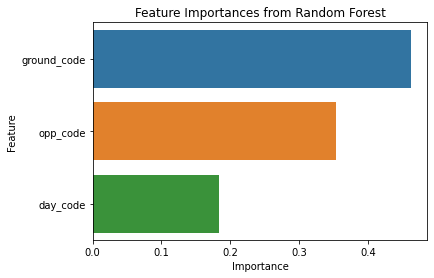

In [7]:
importances = model.feature_importances_
feature_names = predictors
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Chapter 3: Improvements
---
Using the metric gathered earlier, it is possible to use past data to improve predictions. Firstly, a rolling windows was used and the mean computed for the last 5 matches for each statistic. This was then compared to a weighted statistic, where recent matches are weighted more heavily, which also handily increases the size of the training set. (Note: The warnings raised by innaccurate precision is due to the complete inaccuracy in predicting draws)

In [8]:
def make_predictions(data, predictors):
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()
    train = data[data['Match Date'] < '2023-01-01']
    test = data[data['Match Date'] >= '2023-01-01']
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test['target'], prediction=preds), index=test.index)
    precision = precision_score(test['target'], preds, average='weighted')
    return combined, precision

In [9]:
cols = ['RR', 'batting_average', 'BP', 'SR', 'bowling_average', 'ER', 'balls_per_wicket']
new_cols = [f'{col}_rolling' for col in cols]

In [10]:
grouped_matches = matches.groupby('Team')

In [11]:
def rolling_average(group, cols, new_cols):
    group = group.sort_values('Match Date')
    rolling_stats = group[cols].rolling(6, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

As can be seen, the precision doesn't improve at all using this new data with a precision of ~ 47%.

In [12]:
matches_rolling = matches.groupby('Team').apply(lambda x: rolling_average(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('Team')
combined, precision = make_predictions(matches_rolling, predictors + new_cols)
precision

/Users/tomborrett/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.46759579674940177

Looking at tests where the model strongly predicts one winner i.e. predicts the same winner and loser for each team in each match independently, 'double predict' precision goes up to 61%. 

In [13]:
combined = combined.merge(matches_rolling[['Team', 'Opposition', 'Winner', 'Match Date']], left_index=True, right_index=True)
merged = combined.merge(combined, left_on=['Match Date', 'Team'], right_on=['Match Date', 'Opposition'])
score = merged[(merged['prediction_x'] == 1) & (merged['prediction_y'] == -1)]['actual_x'].value_counts()
score

 1    20
-1     8
 0     5
Name: actual_x, dtype: int64

In [14]:
score[1]/score.sum()

0.6060606060606061

Now, instead of a simple rolling window, an exponential decaying weight is applied to the previous matches with a decay rate of 100 days. With these improved rolling statisitcs, the precision of the model greatly improves.

In [15]:
def calculate_weighted_average(group, date, col, decay_factor=500):
    group_filtered = group[group['Match Date'] < date].copy()
    if group_filtered.empty:
        return np.NaN
    group_filtered['Days Since'] = (group_filtered['Match Date'].max() - group_filtered['Match Date']).dt.days
    group_filtered['weights'] = np.exp(-group_filtered['Days Since'] / decay_factor)
    group_filtered['weighted_average'] = (group_filtered[col] * group_filtered['weights']).cumsum() / group_filtered['weights'].cumsum()
    return group_filtered['weighted_average'].iloc[-1]

def weighted_average(group, cols, new_cols):
    group = group.sort_values('Match Date')
    rolling_stats = pd.DataFrame(index=group.index, columns=new_cols)
    for col, new_col in zip(cols, new_cols):
        rolling_stats[new_col] = [calculate_weighted_average(group, date, col) for date in group['Match Date']]
    group = group.join(rolling_stats)
    group = group.dropna(subset=new_cols)
    return group

In [16]:
matches_rolling = matches.groupby('Team').apply(lambda x: weighted_average(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('Team')
combined, precision = make_predictions(matches_rolling, predictors + new_cols)

In [17]:
matches_rolling.to_pickle('data/matches_rolling.pkl')

Precision has now increased to ~ 60% on the same test data, much better than previously.

In [18]:
precision

0.6034436843925259

In [19]:
combined = combined.merge(matches_rolling[['Team', 'Opposition', 'Winner', 'Match Date']], left_index=True, right_index=True)
merged = combined.merge(combined, left_on=['Match Date', 'Team'], right_on=['Match Date', 'Opposition'])
score = merged[(merged['prediction_x'] == 1) & (merged['prediction_y'] == -1)]['actual_x'].value_counts()
score

 1    18
-1     9
 0     1
Name: actual_x, dtype: int64

Again looking at matches where the model 'ouble predicts' the outcome, the precision goes up to 64% on the same test data!

In [20]:
score[1] / score.sum()

0.6428571428571429